<a href="https://colab.research.google.com/github/Deep-Learning-Assignment/Deep-Learning-Project/blob/IT21156656-experiment2/IT21156656.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Dataset
Download the dataset from the kaggle to the google drive

In [1]:
import zipfile
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install split-folders

### Split the Dataset
Split dataset into train (70%), validation (20%), and test (10%)


In [3]:
import splitfolders

# Path to the folder where your dataset is located
input_folder = '/content/drive/MyDrive/datasets/tomato data'

# Split dataset into train (70%), validation (20%), and test (10%)
splitfolders.ratio(input_folder, output="/content/drive/MyDrive/datasets/tomato data/split_data", seed=42, ratio=(.7, .2, .1))

print("Dataset has been split into training, validation, and test sets.")


Copying files: 16012 files [05:01, 53.16 files/s]

Dataset has been split into training, validation, and test sets.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Setting up the Data Augmentation

In [5]:
# Create an ImageDataGenerator for the training set with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalize pixel values to [0, 1]
    rotation_range=40,    # Randomly rotate images by 40 degrees
    width_shift_range=0.2, # Shift the image horizontally by 20%
    height_shift_range=0.2, # Shift the image vertically by 20%
    shear_range=0.2,      # Apply shearing transformations
    zoom_range=0.2,       # Randomly zoom in on images
    horizontal_flip=True, # Flip images horizontally
    fill_mode='nearest'   # Fill any missing pixels after rotation/shift with nearest pixel
)

# Create ImageDataGenerator for validation and test sets (only rescale the images)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Define the directories for train, validation, and test sets
train_dir = '/content/drive/MyDrive/datasets/tomato data/split_data/train'
val_dir = '/content/drive/MyDrive/datasets/tomato data/split_data/val'
test_dir = '/content/drive/MyDrive/datasets/tomato data/split_data/test'

# Load the images and resize them to 224x224 (standard input size for VGG16)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize to 224x224
    batch_size=32,           # Batch size
    class_mode='categorical' # Since it's a multi-class classification
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 11203 images belonging to 11 classes.
Found 3198 images belonging to 11 classes.
Found 1610 images belonging to 11 classes.


In [6]:
num_classes = train_generator.num_classes  # Should return the number of classes
print(f"Number of classes: {num_classes}")

num_classes = 11  # Set this to the actual number of classes


Number of classes: 11


In [7]:
batch = next(train_generator)

# Print the shape of the images and labels
print(f"Batch image shape: {batch[0].shape}")  # This should be (batch_size, 224, 224, 3)
print(f"Batch label shape: {batch[1].shape}")

Batch image shape: (32, 224, 224, 3)
Batch label shape: (32, 11)


### Buid The Model and Compile it

In [26]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Define the input shape
input_tensor = Input(shape=(224, 224, 3))

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the first 20 layers
for layer in base_model.layers[:20]:
    layer.trainable = False

# Build the model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)                   # Add a Dropout layer
output = Dense(num_classes, activation='softmax')(x)  # Output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Print the model summary
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 49,280,907 (187.99 MB)

 Trainable params: 49,126,091 (187.40 MB)

 Non-trainable params: 154,816 (604.75 KB)

#### Run the model

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [28]:
# Set up a learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy', # Monitor validation accuracy
    factor=0.5,            # Reduce learning rate by half
    patience=3,            # Wait for 3 epochs before reducing
    min_lr=1e-6            # Minimum learning rate
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,              # Set the number of epochs
    callbacks=[lr_scheduler, early_stopping] # Add the learning rate scheduler
)


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 229s 510ms/step - accuracy: 0.2871 - loss: 2.4850 - val_accuracy: 0.1091 - val_loss: 3.5313 - learning_rate: 1.0000e-05
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 160s 448ms/step - accuracy: 0.5181 - loss: 1.4137 - val_accuracy: 0.6651 - val_loss: 0.9552 - learning_rate: 1.0000e-05
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 160s 446ms/step - accuracy: 0.6328 - loss: 1.1063 - val_accuracy: 0.6285 - val_loss: 1.1185 - learning_rate: 1.0000e-05
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 159s 445ms/step - accuracy: 0.6940 - loss: 0.9039 - val_accuracy: 0.7280 - val_loss: 0.8204 - learning_rate: 1.0000e-05
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 160s 447ms/step - accuracy: 0.7304 - loss: 0.7821 - val_accuracy: 0.6648 - val_loss: 1.1325 - learning_rate: 1.0000e-05
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 160s 448ms/step - accuracy: 0.7628 - loss: 0.6963 - val_accuracy: 0.7398 - val_loss: 0.7964 - learning_rate: 1.0000e-05
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 

In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8865 - loss: 0.2933
Test Loss: 0.2999
Test Accuracy: 0.8913


In [14]:
!pip install matplotlib


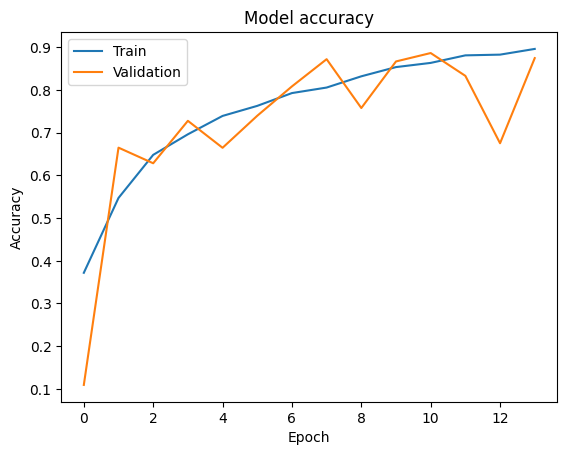

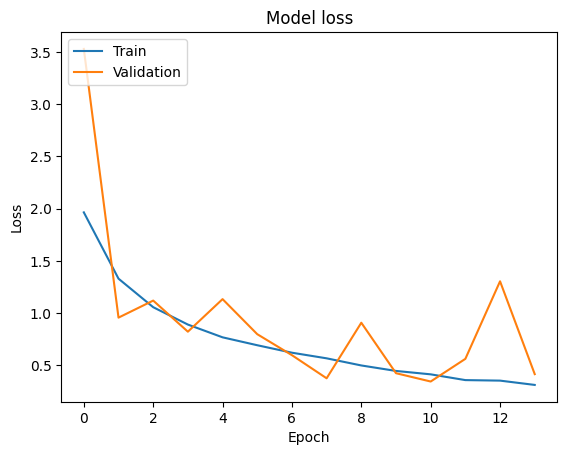

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [32]:
# Save the model to a file
model.save('tomato_disease_classification_model.h5')
print("Model saved successfully.")

Model saved successfully.


In [31]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [33]:
# Load the trained model
model = load_model('tomato_disease_classification_model.h5')


### Evaluate the Model

In [34]:
def preprocess_image(image_path):
    # Load the image with the target size for VGG16
    image = load_img(image_path, target_size=(224, 224))
    # Convert the image to a numpy array
    image = img_to_array(image)
    # Scale the pixel values to [0, 1]
    image = image / 255.0
    # Expand dimensions to match the model input
    image = np.expand_dims(image, axis=0)
    return image


In [35]:
def predict_image(image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path)
    # Make predictions
    predictions = model.predict(processed_image)
    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)[0]
    return predicted_class


In [36]:
import os

def get_class_names(data_dir):
    class_names = sorted([folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))])
    return class_names

# Usage
data_dir = '/content/drive/MyDrive/datasets/tomato data'  # Replace with the path to your dataset directory
class_names = get_class_names(data_dir)

print("Class names:", class_names)

Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy', 'split_data']


In [37]:
# Replace these with your actual class names based on the folder structure
Class_names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']  # Add all classes
def get_class_name(class_index):
    return class_names[class_index]

In [38]:
# Path to the test image
image_path = '/content/drive/MyDrive/datasets/tomato data/split_data/test/Tomato_healthy/02b4afdf-e1de-4c0e-a38d-3f19afeb9ea9___RS_HL 0493.JPG'  # Replace with your image path

# Get predicted class index
predicted_class_index = predict_image(image_path)
# Get predicted class name
predicted_class_name = get_class_name(predicted_class_index)

print(f"Predicted class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Tomato_healthy
